<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))
dfCovidtracking.set_index(['date'], inplace=True)


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-27-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [98]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-05-26,1671035,93093,16206.0,629.0
2020-05-27,1689630,94352,18595.0,1259.0
2020-05-28,1712637,95705,23007.0,1353.0


In [99]:
dfCovidtracking.loc[dfCovidtracking.state=='CA'].groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']].head(5)

,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-05-26,96733,3814,2175.0,19.0
2020-05-27,98980,3884,2247.0,70.0
2020-05-28,101697,3973,2717.0,89.0


In [100]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.index.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 1712637
Total deaths = 95705


,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
state,,,,,,,,,,,,,,,,,,,,,,,,,
NY,366733,1510056,0,4010.0,78043.0,1219.0,0.0,931.0,0.0,64954.0,A,5/28/2020 00:00,bc0a13ef57e5405d70899664f175c10af1327dde,2020-05-28T20:00:00Z,23722,78043.0,1876789,1876789,1876789,36,79.0,205.0,63477.0,1768.0,65245.0
NJ,157815,528042,0,2797.0,16778.0,740.0,0.0,564.0,0.0,25804.0,A+,5/28/2020 13:00,8c07b34e421f01a33bdbeb9776805936d9fd953b,2020-05-28T20:00:00Z,11401,16778.0,685857,685857,685857,34,62.0,181.0,24345.0,1187.0,25532.0
IL,115833,714133,0,3649.0,0.0,1009.0,0.0,576.0,0.0,0.0,A,5/28/2020 00:00,e1b1875c6d981adf1ee8074b1e73bdfa026e263d,2020-05-28T20:00:00Z,5186,0.0,829966,829966,829966,17,103.0,0.0,24466.0,1527.0,25993.0
CA,101697,1688862,0,4529.0,0.0,1325.0,0.0,0.0,0.0,0.0,B,5/28/2020 00:00,0d6445cf4d68a90656e6555a195d5a9962ef31d6,2020-05-28T20:00:00Z,3973,0.0,1790559,1790559,1790559,06,89.0,0.0,50948.0,2717.0,53665.0
MA,94895,467428,0,2112.0,9618.0,529.0,0.0,0.0,0.0,0.0,A,5/28/2020 10:00,105e052b4e29072082da566bd62689b53a509d2a,2020-05-28T20:00:00Z,6640,9618.0,562323,562323,562323,25,167.0,230.0,15640.0,1202.0,16842.0


In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [102]:
dfUSAPos[-7:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,pos_pct
121,2020-05-22,1592656,13419058,90196,24159.0,1280.0,0.929944
122,2020-05-23,1614954,13784786,91287,22298.0,1091.0,0.942963
123,2020-05-24,1635760,14163694,91941,20806.0,654.0,0.955112
124,2020-05-25,1654829,14604942,92464,19069.0,523.0,0.966246
125,2020-05-26,1671035,14907041,93093,16206.0,629.0,0.975709
126,2020-05-27,1689630,15192481,94352,18595.0,1259.0,0.986566
127,2020-05-28,1712637,15646041,95705,23007.0,1353.0,1.000000


In [103]:
dfStatePos[-7:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,pos_pct
79,2020-05-22,88444,1466773,3630,2247.0,88.0,0.869682
80,2020-05-23,90631,1515306,3708,2187.0,78.0,0.891187
81,2020-05-24,92710,1582745,3774,2079.0,66.0,0.911630
82,2020-05-25,94558,1644102,3795,1848.0,21.0,0.929801
83,2020-05-26,96733,1696396,3814,2175.0,19.0,0.951188
84,2020-05-27,98980,1736894,3884,2247.0,70.0,0.973283
85,2020-05-28,101697,1790559,3973,2717.0,89.0,1.000000


In [104]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-24,1635760,12527934,3860,36706.0,172574.0,8487.0,7801.0,4383.0,639.0,366736.0,91941,172574.0,14167554,14163694,14163694,654.0,537.0,358102.0,20806.0,378908.0
2020-05-25,1654829,12950113,3368,36668.0,173541.0,8472.0,7847.0,4237.0,642.0,379157.0,92464,173541.0,14608310,14604942,14604942,523.0,967.0,422179.0,19069.0,441248.0
2020-05-26,1671035,13236006,1549,36609.0,190823.0,8585.0,7899.0,4215.0,650.0,384902.0,93093,190823.0,14908590,14907041,14907041,629.0,17282.0,285893.0,16206.0,302099.0
2020-05-27,1689630,13502851,3132,37253.0,192446.0,8551.0,8015.0,4222.0,666.0,391508.0,94352,192446.0,15195613,15192481,15192481,1259.0,1623.0,266845.0,18595.0,285440.0
2020-05-28,1712637,13933404,1906,36967.0,194975.0,8389.0,8109.0,4080.0,676.0,399991.0,95705,194975.0,15647947,15646041,15646041,1353.0,2529.0,430553.0,23007.0,453560.0


In [105]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-24,92710,1490035,0,4300.0,0.0,1315.0,0.0,0.0,0.0,0.0,3774,0.0,1582745,1582745,1582745,66.0,0.0,65360.0,2079.0,67439.0
2020-05-25,94558,1549544,0,4306.0,0.0,1301.0,0.0,0.0,0.0,0.0,3795,0.0,1644102,1644102,1644102,21.0,0.0,59509.0,1848.0,61357.0
2020-05-26,96733,1599663,0,4404.0,0.0,1392.0,0.0,0.0,0.0,0.0,3814,0.0,1696396,1696396,1696396,19.0,0.0,50119.0,2175.0,52294.0
2020-05-27,98980,1637914,0,4544.0,0.0,1407.0,0.0,0.0,0.0,0.0,3884,0.0,1736894,1736894,1736894,70.0,0.0,38251.0,2247.0,40498.0
2020-05-28,101697,1688862,0,4529.0,0.0,1325.0,0.0,0.0,0.0,0.0,3973,0.0,1790559,1790559,1790559,89.0,0.0,50948.0,2717.0,53665.0


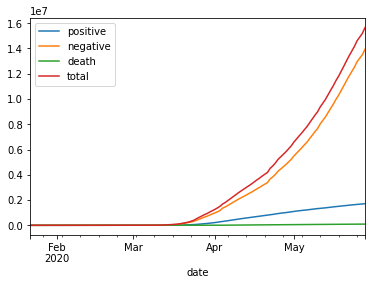

In [106]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

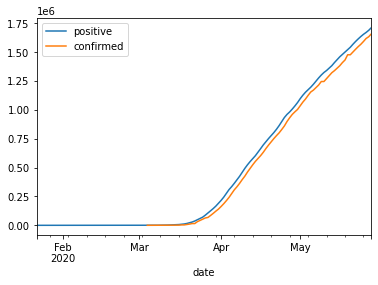

In [107]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [108]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1699176
dead          100418
dtype: int64

In [109]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    101050
dead           3895
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [111]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1699176
Brazil             411821
Russia             370680
United Kingdom     268619
Spain              236259
Italy              231139
France             183038
Germany            181524
Turkey             159797
India              158086
Name: confirmed, dtype: int64

In [112]:
dfctd_state_curr.head()

,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
state,,,,,,,,,,,,,,,,,,,,,,,,,
AK,425,47545,0,10.0,0.0,0.0,0.0,0.0,0.0,366.0,B,5/28/2020 00:00,37e60616c88a6df069f2a7030ec9f82b3978cb83,2020-05-28T20:00:00Z,10,0.0,47970,47970,47970,02,0.0,0.0,1594.0,13.0,1607.0
AL,16310,184171,0,0.0,1765.0,0.0,566.0,0.0,338.0,9355.0,B,5/28/2020 00:00,b774f53f9f66430cb45fa6be6f576eb6ef99e74d,2020-05-28T20:00:00Z,590,1765.0,200481,200481,200481,01,9.0,46.0,4220.0,467.0,4687.0
AR,6538,112364,0,104.0,640.0,0.0,0.0,27.0,118.0,4583.0,A,5/27/2020 19:30,e62e173d8cad6fe1acec1555776aa074b3947e0b,2020-05-28T20:00:00Z,120,640.0,118902,118902,118902,05,0.0,13.0,3045.0,261.0,3306.0
AS,0,174,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,5/27/2020 00:00,c8ab6f4513aca84f90b5b0a8124f6717609418d2,2020-05-28T20:00:00Z,0,0.0,174,174,174,60,0.0,0.0,0.0,0.0,0.0
AZ,17763,185151,0,945.0,2848.0,374.0,0.0,222.0,0.0,4452.0,A+,5/28/2020 00:00,45c769434c737e258af3517aa823e29db459b8c5,2020-05-28T20:00:00Z,857,2848.0,202914,202914,202914,04,26.0,817.0,6147.0,501.0,6648.0


In [0]:
dfState = dfCovidtracking.reset_index()[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [115]:
dfState.loc['FL'].head(7)

,date,positive,death,total_positive,pct
state,,,,,
FL,2020-05-28,53285,2446,53285,1.000000
FL,2020-05-27,52634,2400,53285,0.987783
FL,2020-05-26,52255,2338,53285,0.980670
FL,2020-05-25,51746,2331,53285,0.971118
FL,2020-05-24,50867,2316,53285,0.954621
FL,2020-05-23,50127,2312,53285,0.940734
FL,2020-05-22,49451,2268,53285,0.928047


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

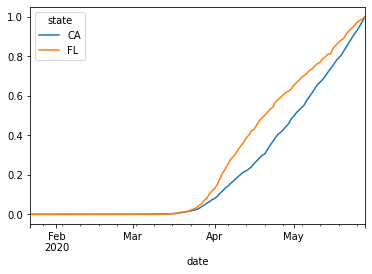

In [117]:
x = res.loc[:, ['CA','FL']].plot.line()

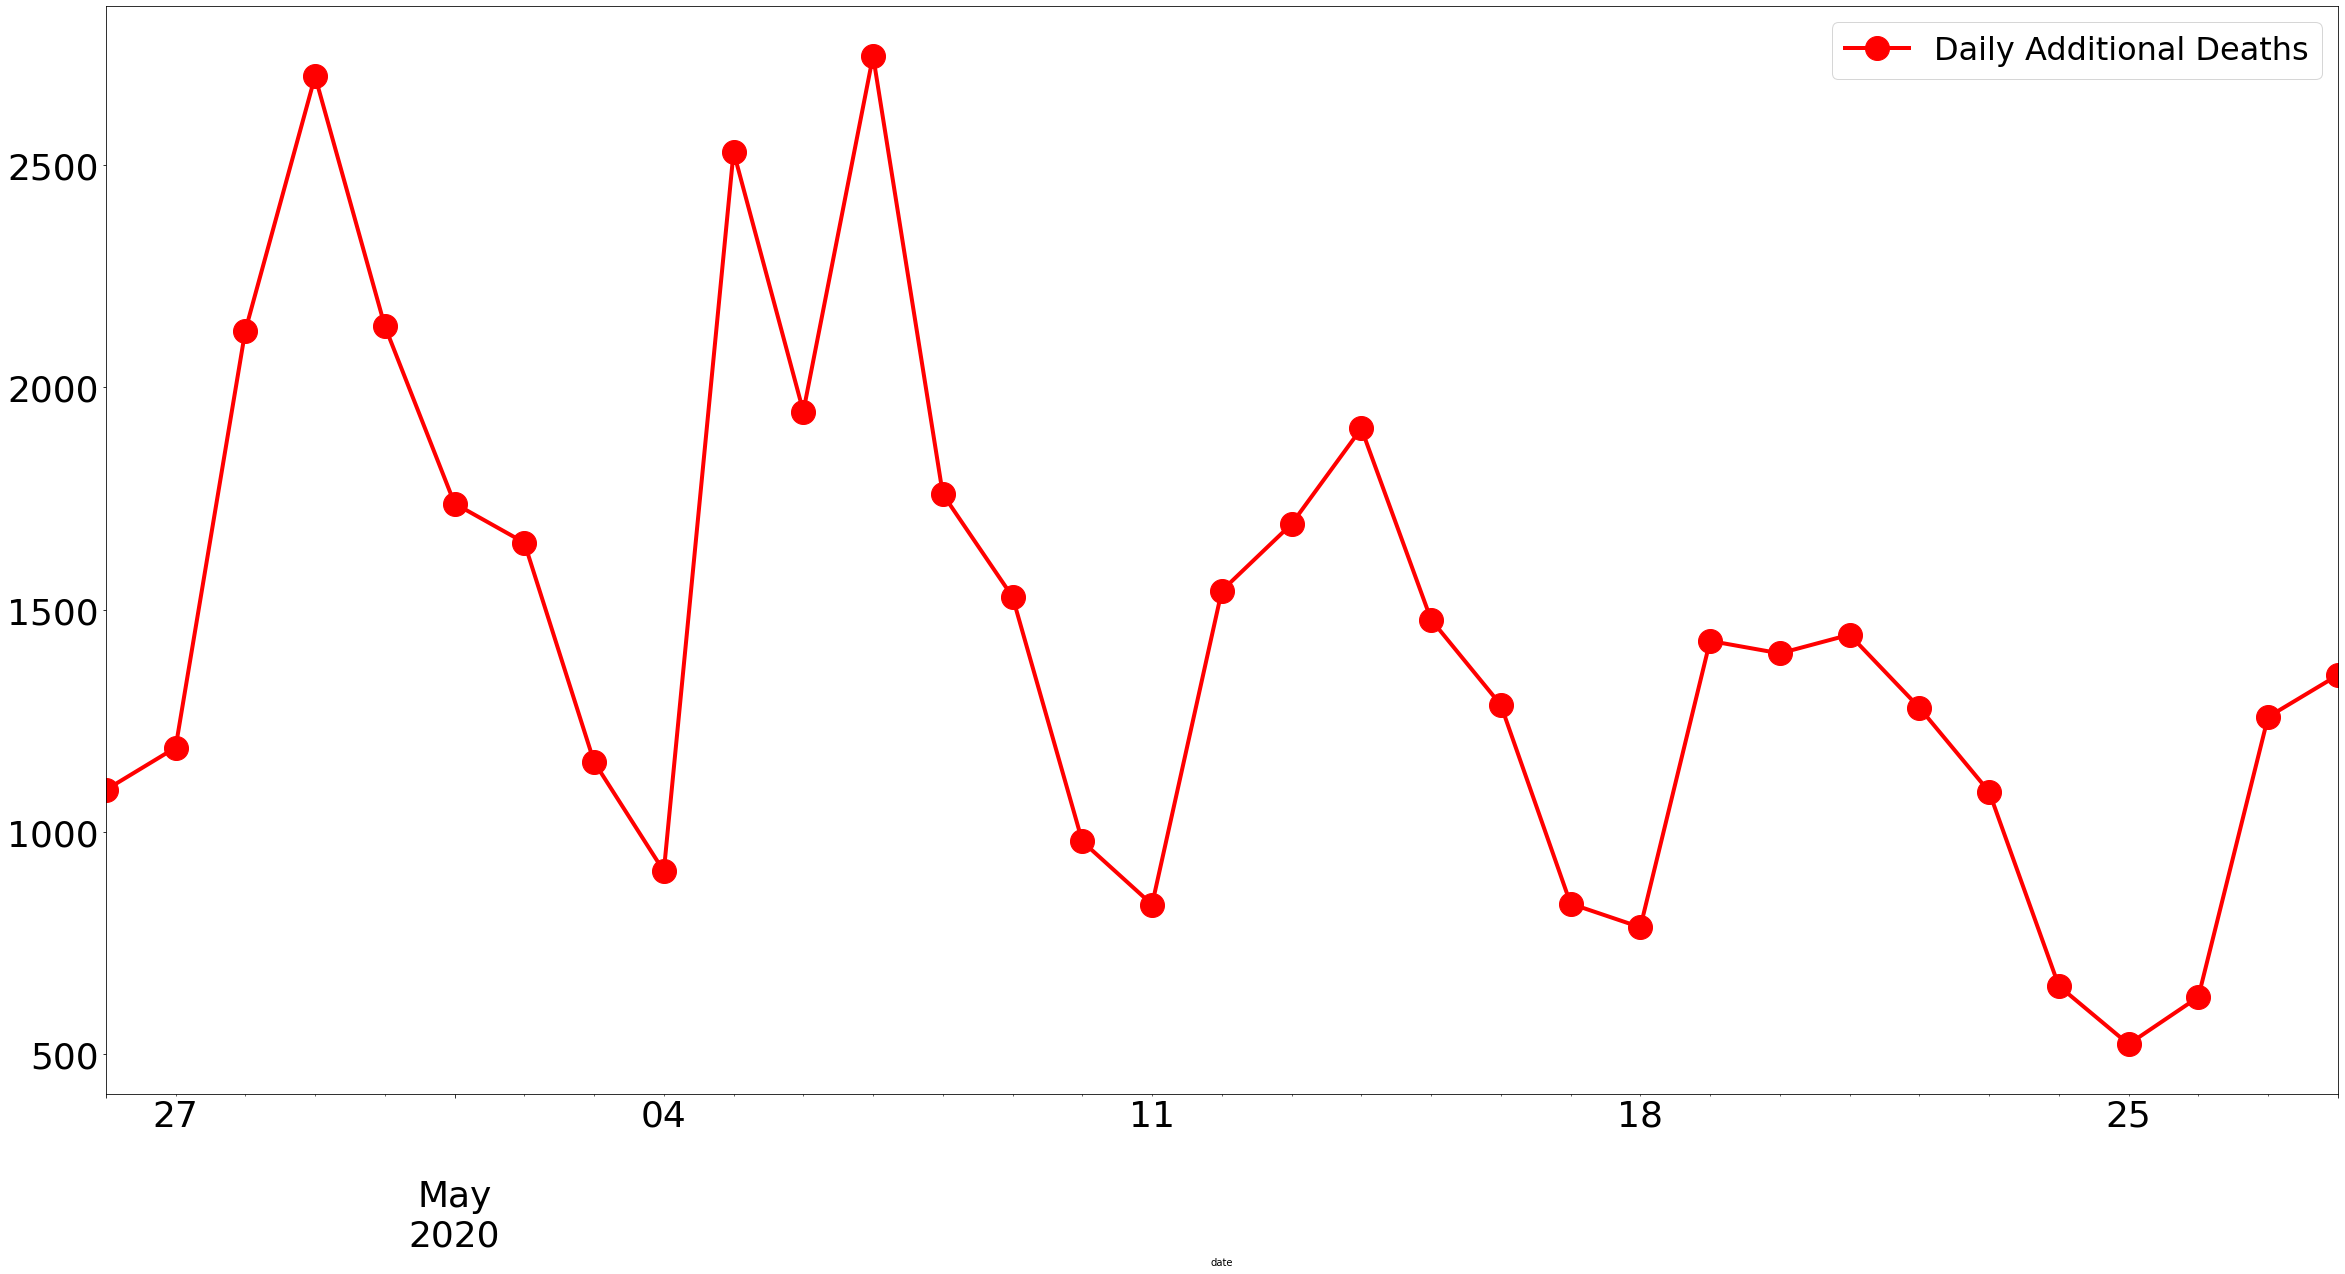

In [118]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


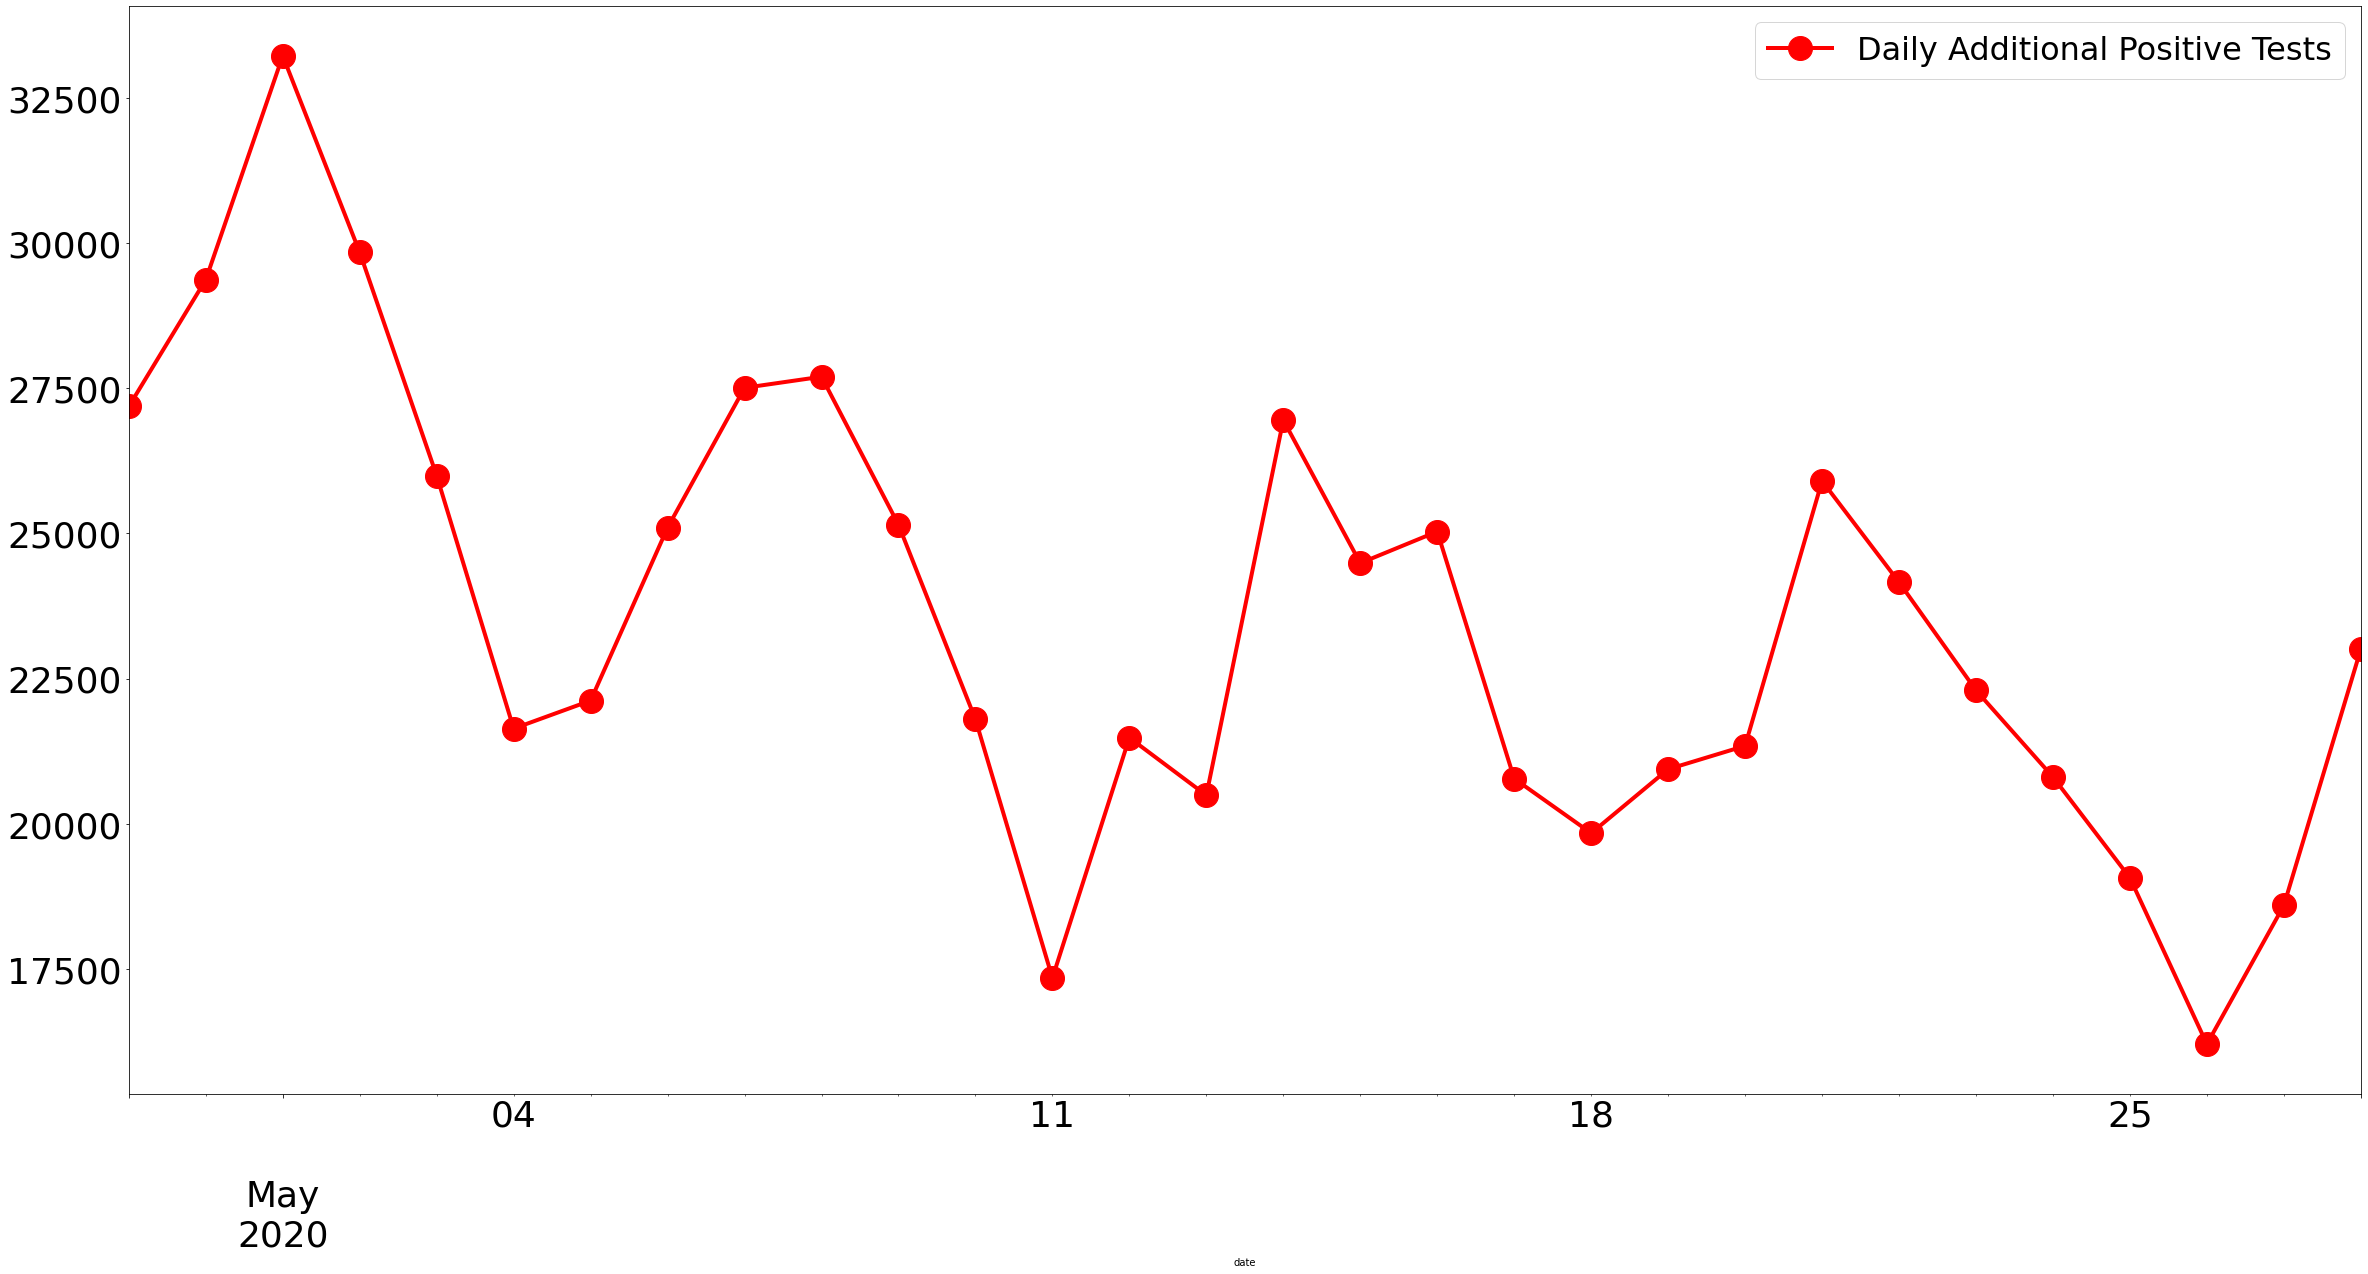

In [119]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


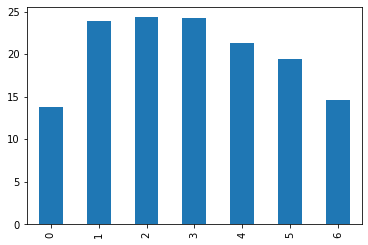

In [122]:
dfDoW.mean().deathIncrease.plot.bar()



In [123]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202016,14063.0,21844.0,844332.0,199843.0,1044175.0
202017,12864.0,18239.0,1319356.0,209064.0,1528420.0
202018,12704.0,24854.0,1462961.0,191865.0,1654826.0
202019,12402.0,18984.0,1747407.0,171010.0,1909104.0
202020,9584.0,12125.0,2324282.0,156568.0,2480850.0
202021,8087.0,15669.0,2548088.0,155287.0,2703375.0
202022,3764.0,22401.0,1405470.0,76877.0,1482347.0


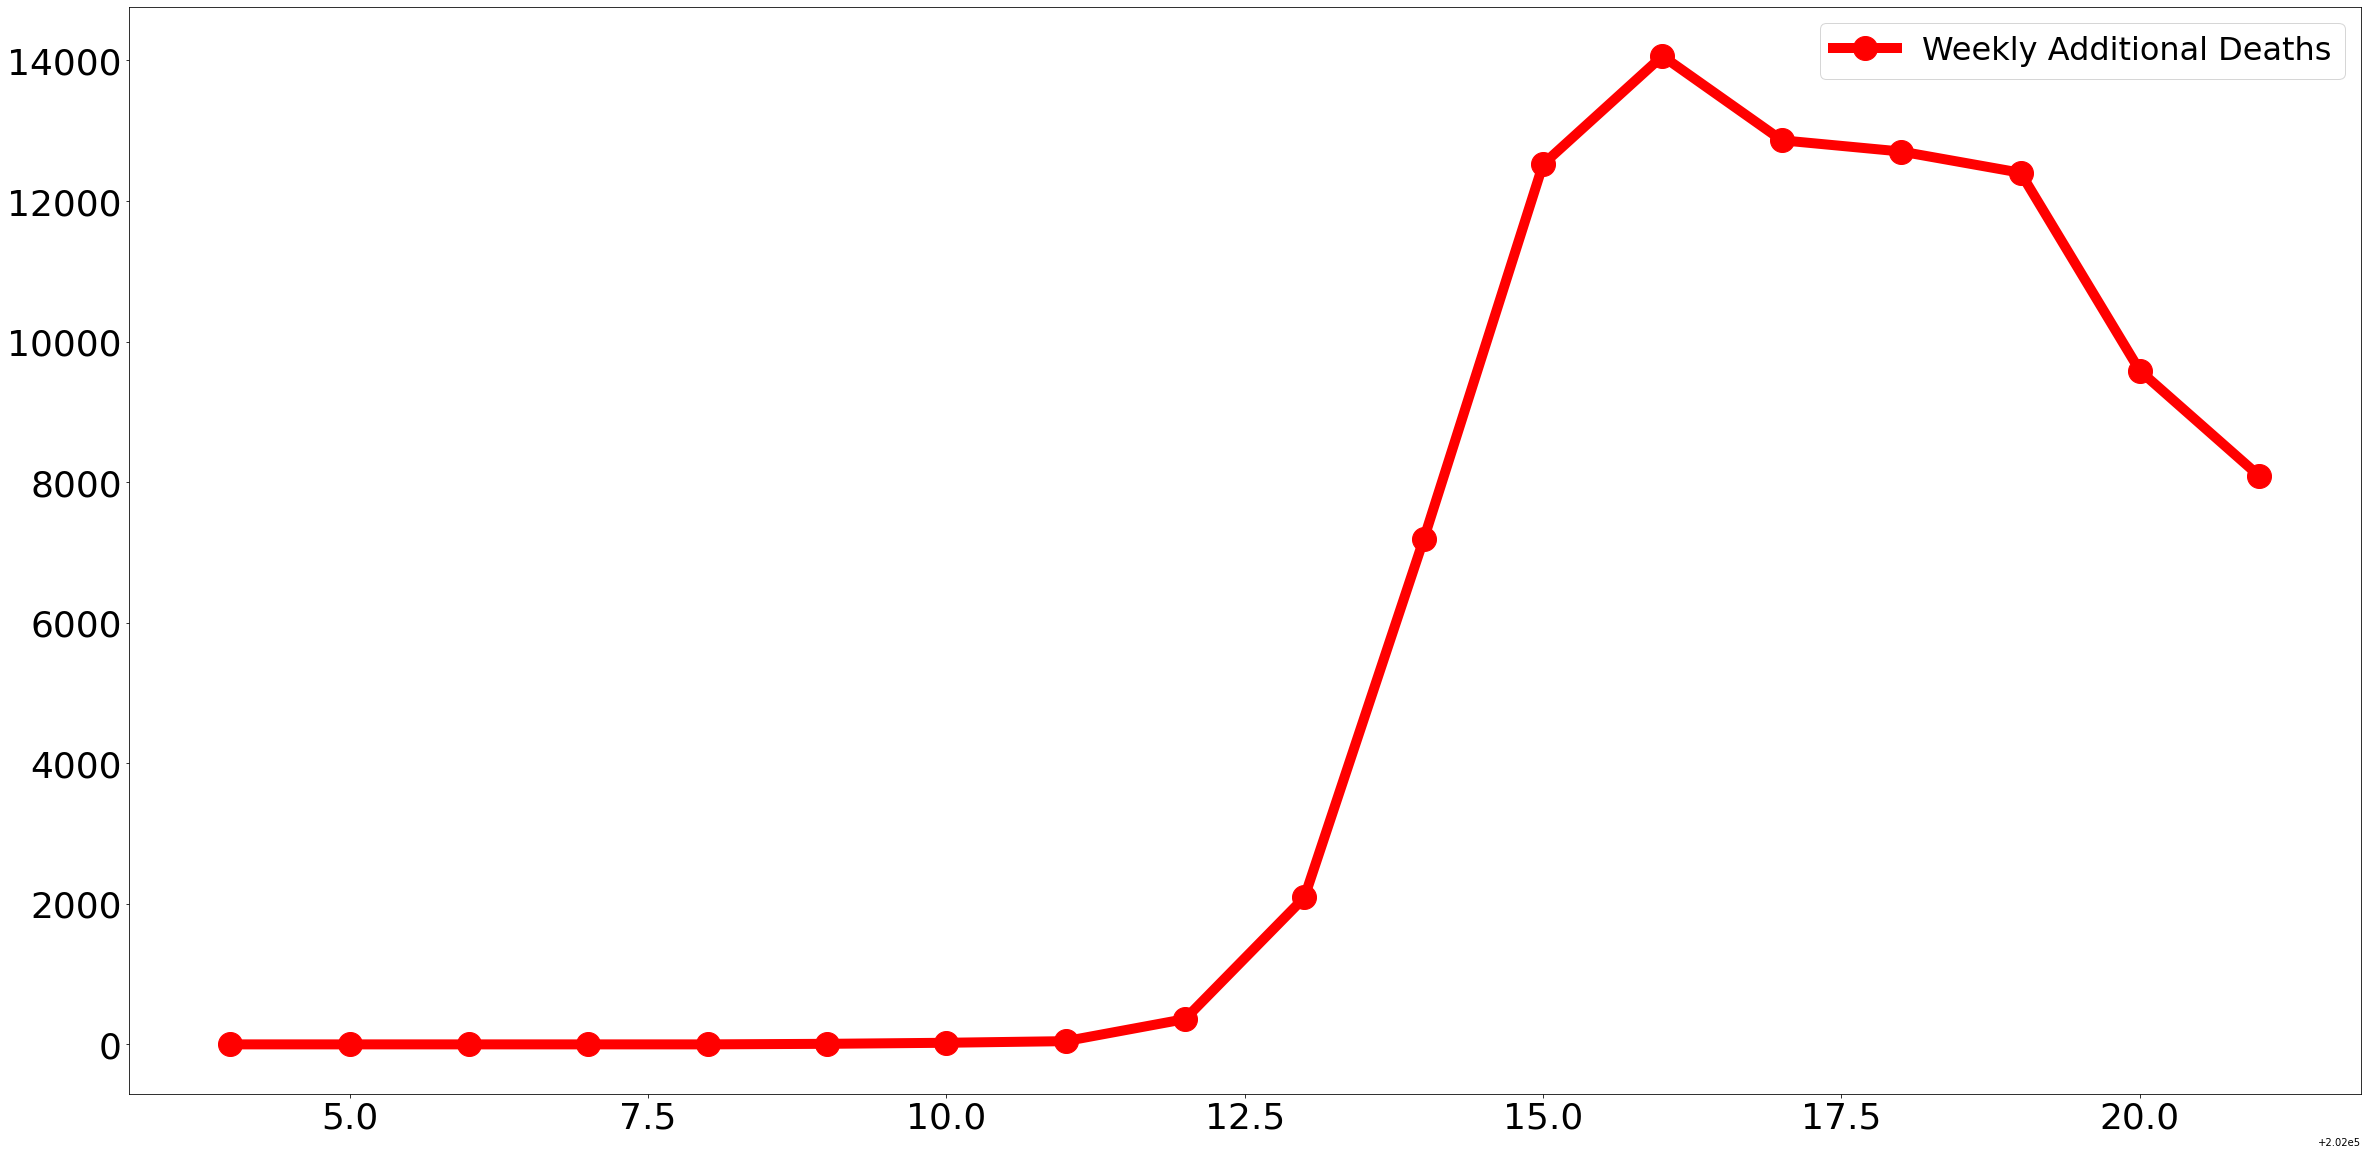

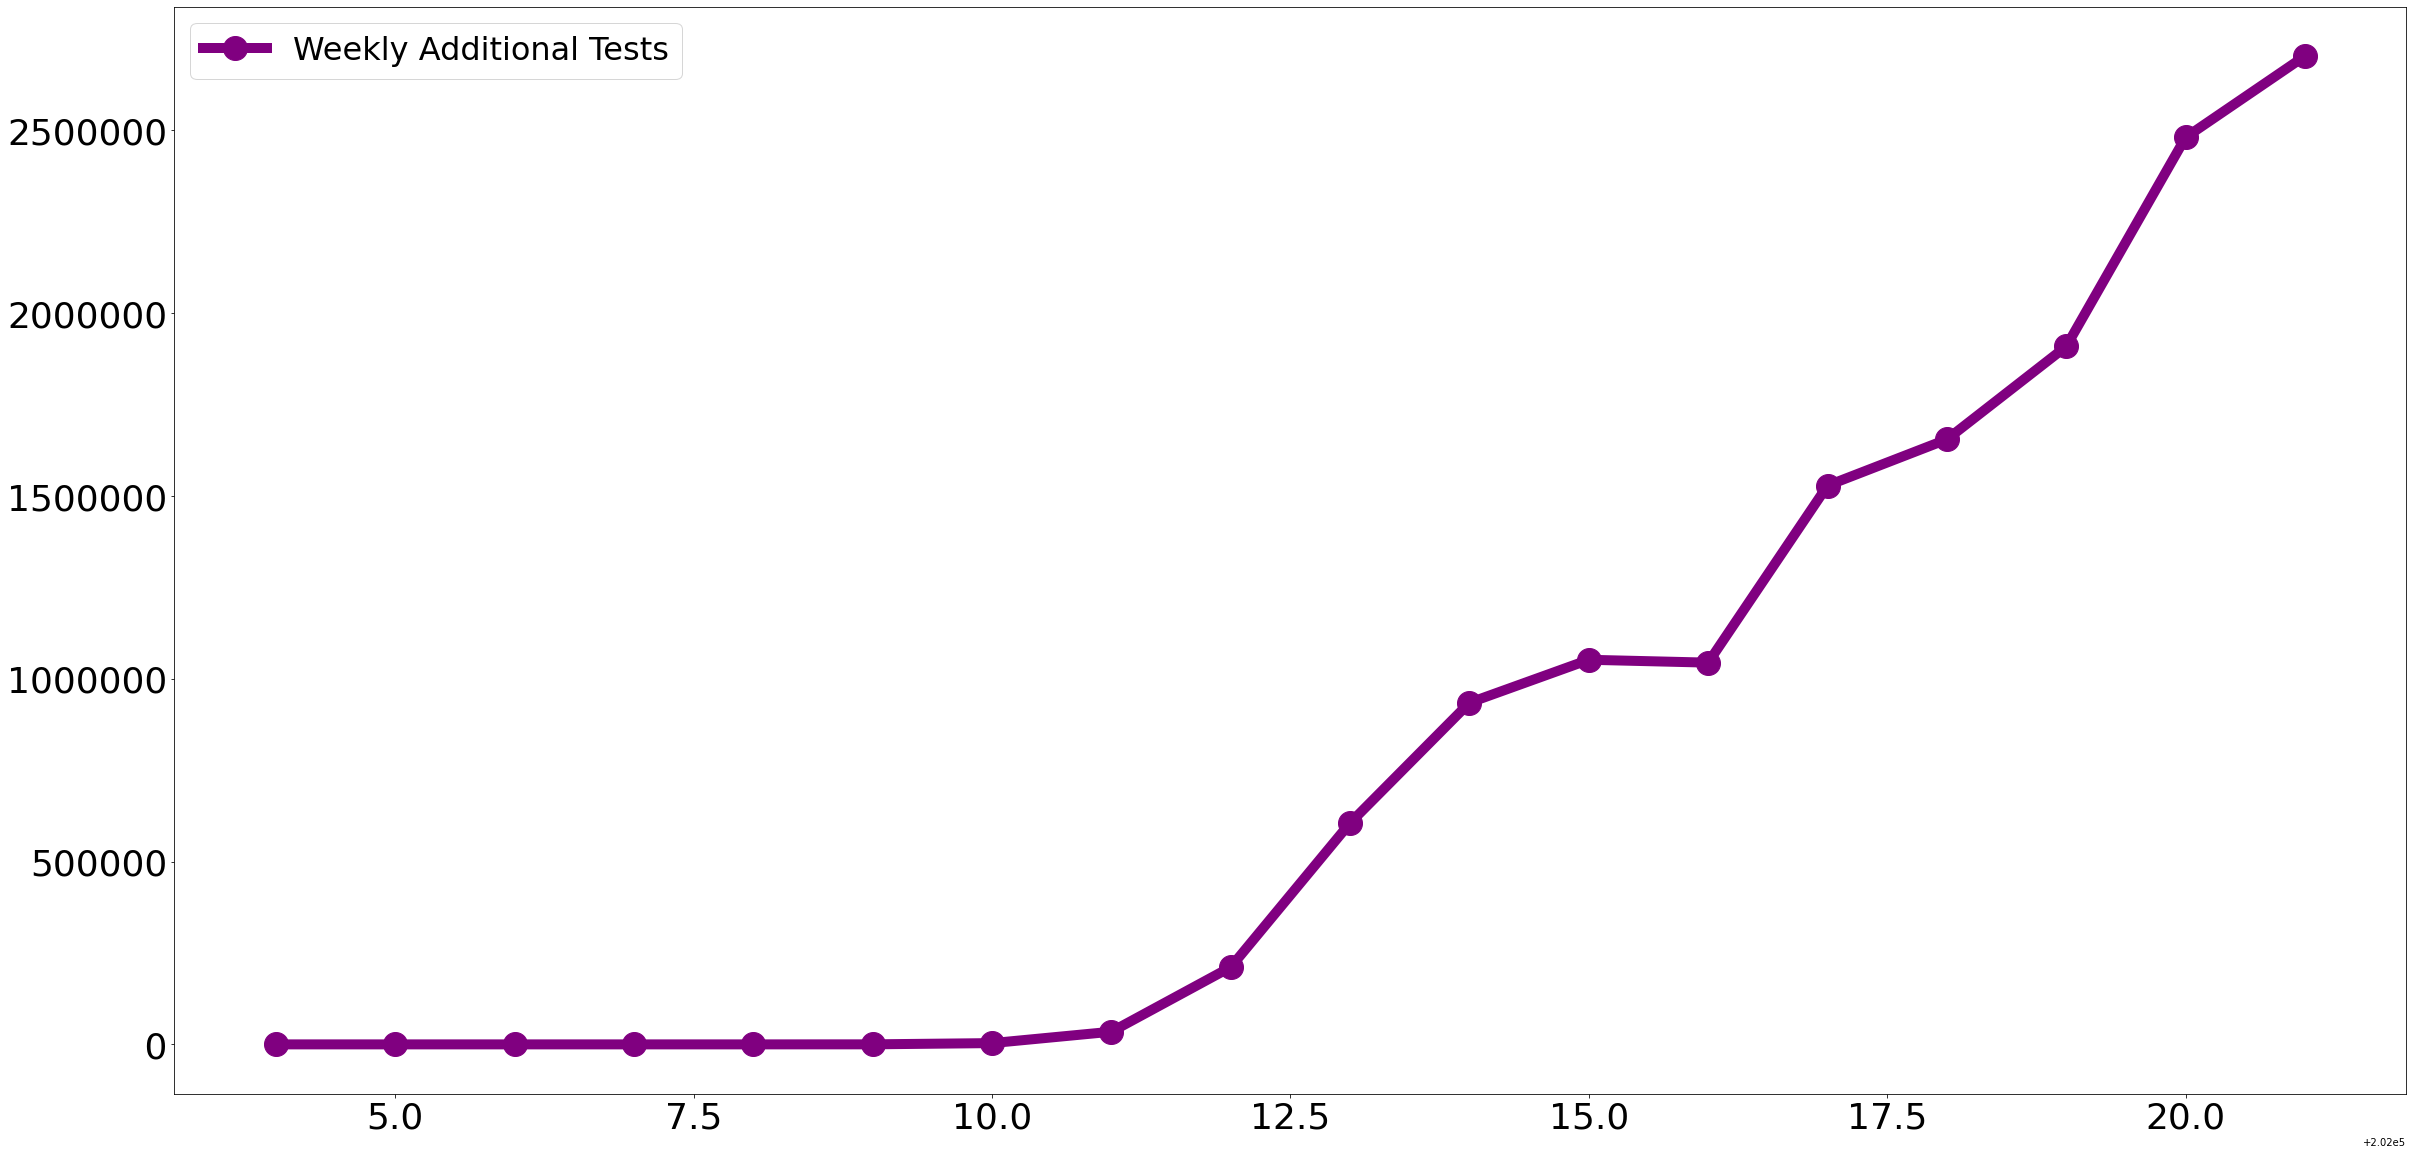

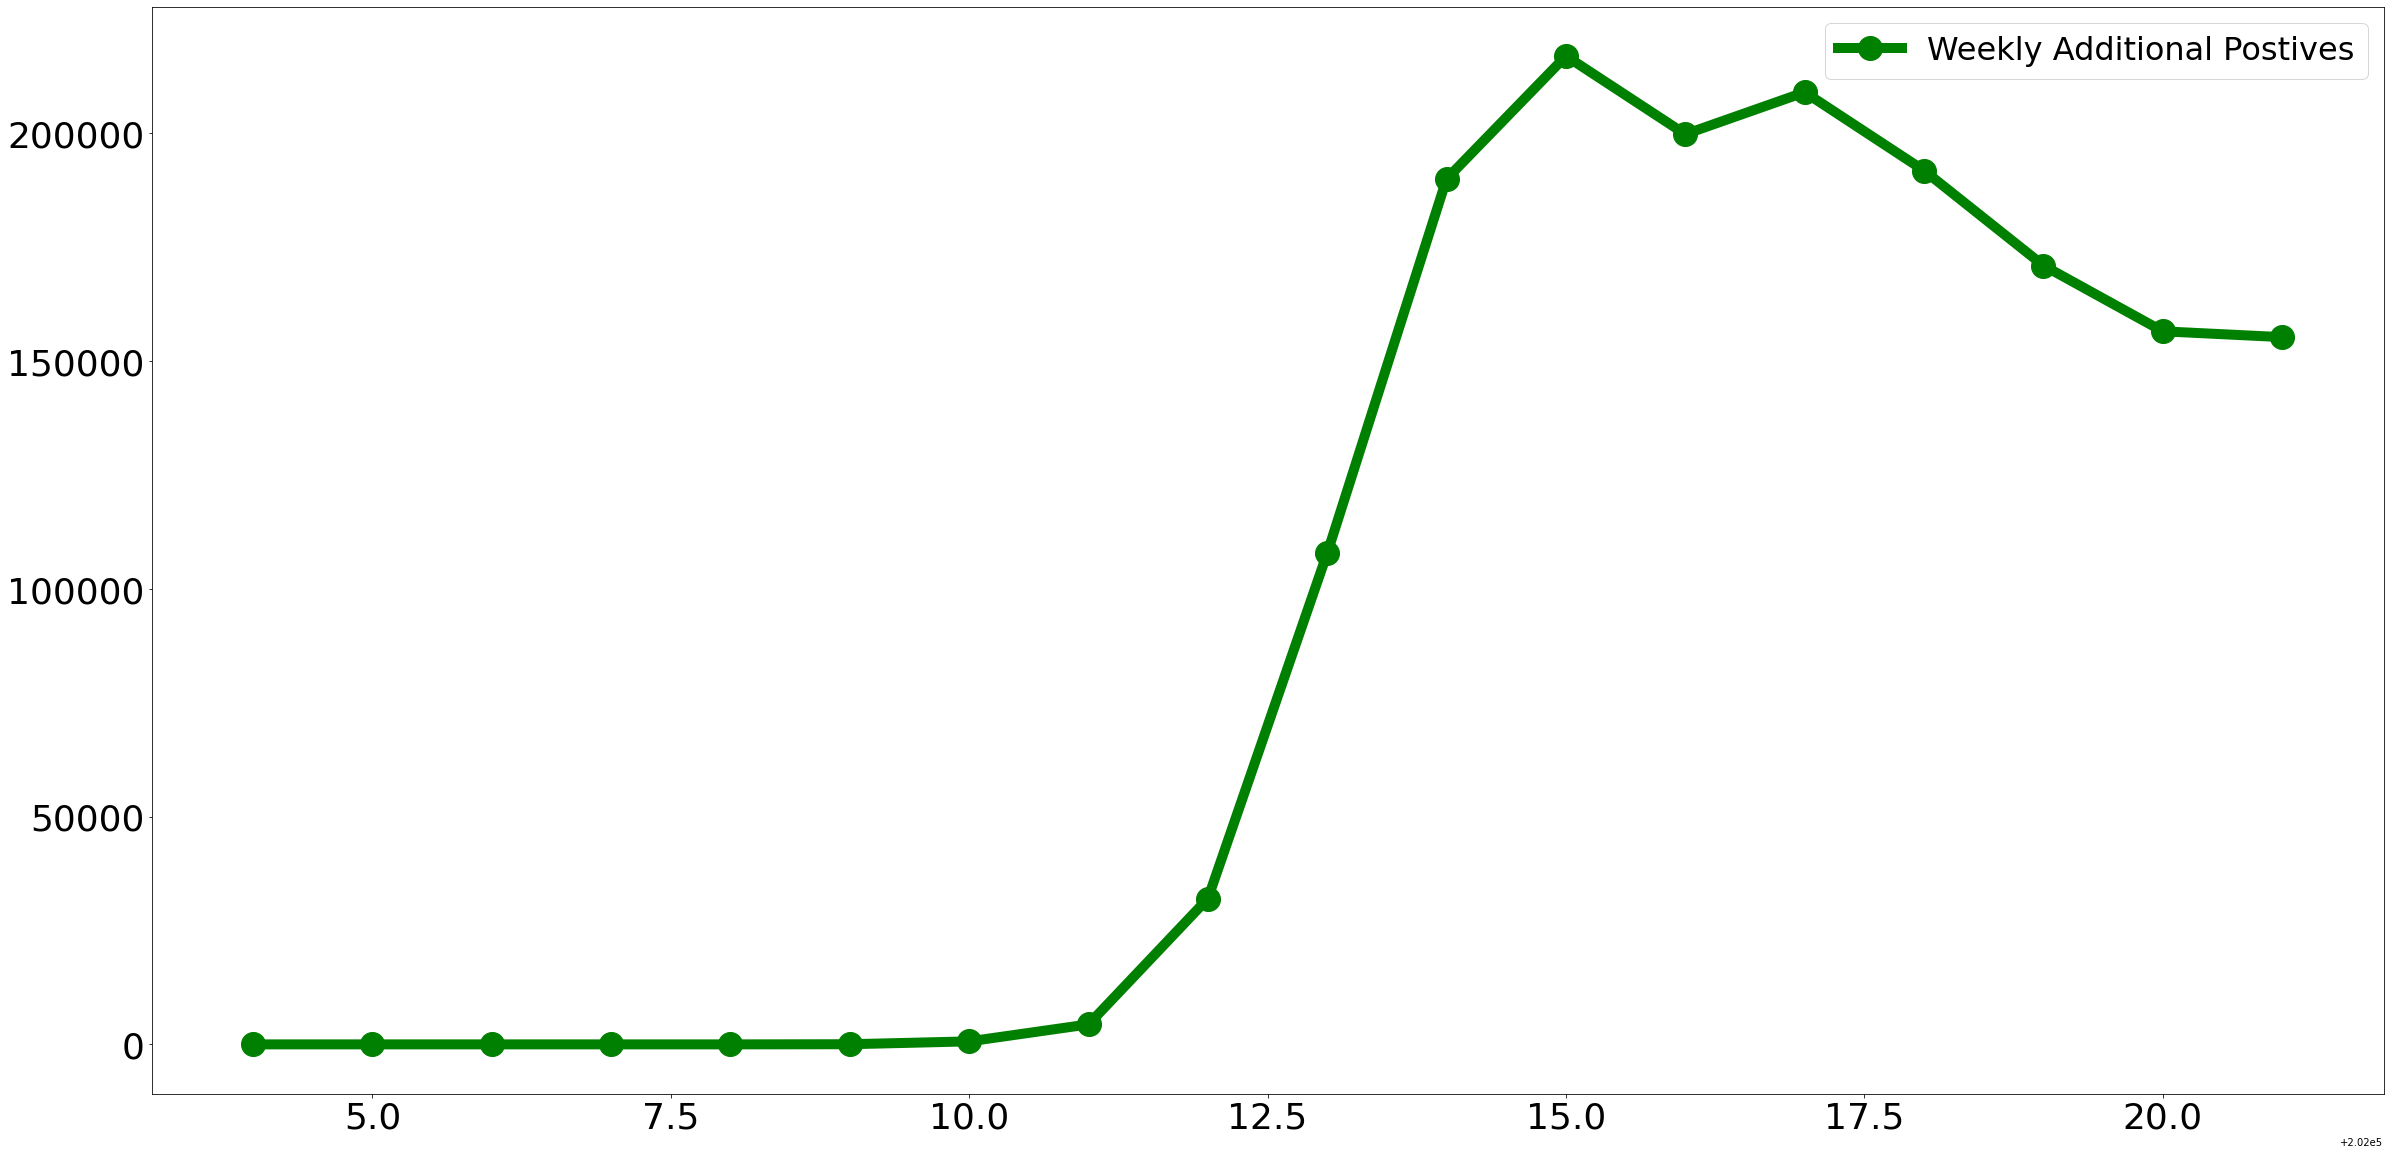

In [124]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

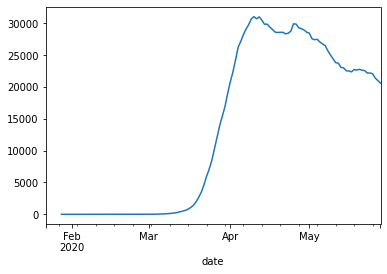

In [125]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

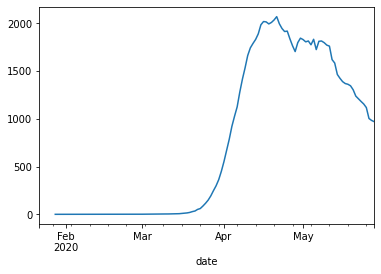

In [126]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

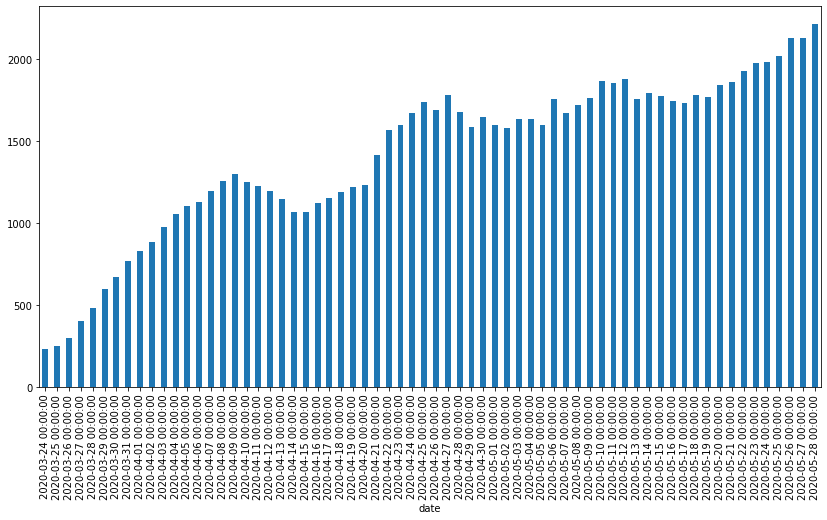

In [128]:

graph1 = dfCAAvg[20:].positiveIncrease.plot.bar(figsize=(14,7))


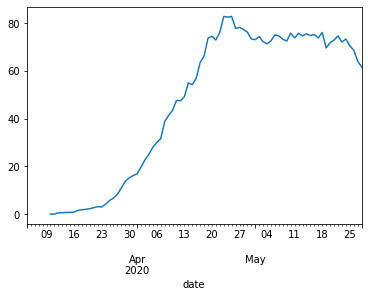

In [129]:
dfCAAvg.deathIncrease.plot.line()

In [130]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['AL']))].head(10)

,state,date,positive,death,total_positive,pct
84,AL,2020-05-28,16310,590,16310,1.000000
85,AL,2020-05-27,15843,581,16310,0.971367
86,AL,2020-05-26,15396,575,16310,0.943961
87,AL,2020-05-25,14730,562,16310,0.903127
88,AL,2020-05-24,14327,551,16310,0.878418
89,AL,2020-05-23,13938,546,16310,0.854568
90,AL,2020-05-22,13563,537,16310,0.831576
91,AL,2020-05-21,13119,529,16310,0.804353
92,AL,2020-05-20,12744,517,16310,0.781361
93,AL,2020-05-19,12376,504,16310,0.758798


In [131]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=14)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .75)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
2100,MN,2020-05-14,13435,663,22947,0.585480
181,AR,2020-05-14,4236,97,6538,0.647905
2507,NC,2020-05-14,16507,615,25412,0.649575
2593,ND,2020-05-14,1647,40,2481,0.663845
4482,WI,2020-05-14,11275,434,16974,0.664251
4111,VA,2020-05-14,27813,955,41401,0.671795
98,AL,2020-05-14,10968,467,16310,0.672471
3525,PR,2020-05-14,2427,117,3486,0.696213
2676,NE,2020-05-14,9075,107,12976,0.699368
339,AZ,2020-05-14,12674,624,17763,0.713506


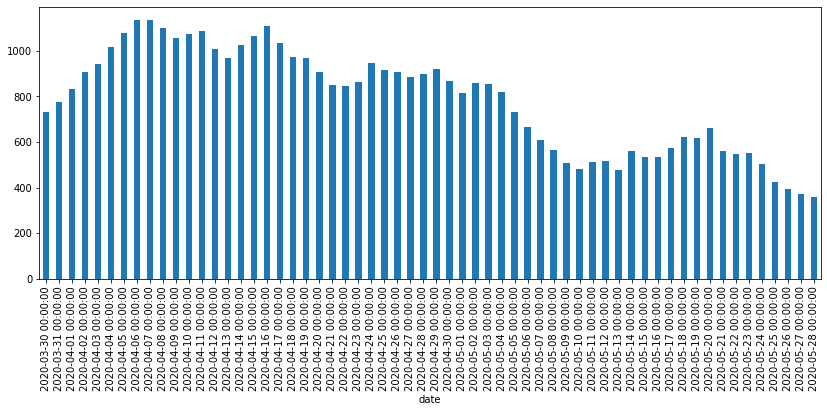

In [180]:

def showStateData(state):
  return dfCovidtracking[dfCovidtracking.state==state]\
  .sort_index()\
  .copy()



chart = showStateData('MI')\
.positiveIncrease\
.rolling(window=7)\
.mean()[-60:].plot.bar(figsize=(14,5))

In [133]:
dfTest = dfCovidtracking[dfCovidtracking.state=='CA'].sort_index().copy()
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4a075d5c57bdb3c2b68cdc0024a0f5c14b77cb67,2020-03-04T21:00:00Z,0,0.0,515,515,515,06,0.0,0.0,0.0,0.0,0.0
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,29660d4104d8a82ef4d69e5359cc586629d587ef,2020-03-05T21:00:00Z,0,0.0,515,515,515,06,0.0,0.0,0.0,0.0,0.0
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0bb79dc4f15a1eb8575ec0ca84b4e6b1f801756f,2020-03-06T21:00:00Z,0,0.0,522,522,522,06,0.0,0.0,0.0,7.0,7.0
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,e233a4c19e477fd4f7bcf450c3a73790f87a5680,2020-03-07T21:00:00Z,0,0.0,531,531,531,06,0.0,0.0,0.0,9.0,9.0
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,a34b3bacf8a39873680d04e62a718fc240a6ab06,2020-03-08T20:00:00Z,0,0.0,550,550,550,06,0.0,0.0,0.0,19.0,19.0


In [134]:
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4a075d5c57bdb3c2b68cdc0024a0f5c14b77cb67,2020-03-04T21:00:00Z,0,0.0,515,515,515,06,0.0,0.0,0.0,0.0,0.0
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,29660d4104d8a82ef4d69e5359cc586629d587ef,2020-03-05T21:00:00Z,0,0.0,515,515,515,06,0.0,0.0,0.0,0.0,0.0
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0bb79dc4f15a1eb8575ec0ca84b4e6b1f801756f,2020-03-06T21:00:00Z,0,0.0,522,522,522,06,0.0,0.0,0.0,7.0,7.0
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,e233a4c19e477fd4f7bcf450c3a73790f87a5680,2020-03-07T21:00:00Z,0,0.0,531,531,531,06,0.0,0.0,0.0,9.0,9.0
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,a34b3bacf8a39873680d04e62a718fc240a6ab06,2020-03-08T20:00:00Z,0,0.0,550,550,550,06,0.0,0.0,0.0,19.0,19.0


# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [137]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.index.max()][['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     1712637
negative    13933404
pending         1906
death          95705
total       15647947
dtype: int64
Current Infection Rate 10.944803%
Percentage of US affected: 0.550921%
Observed CFR: 5.588166%
Percentage of US tested/affected: 4.795811%
Projected affected by cir = 35,925,170
Projected killed = 2,007,559


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.index.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [145]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.885172,9.647534
NJ,1.776758,7.721711
MA,1.376786,8.158473
RI,1.368183,13.249969
DC,1.203261,6.165648
CT,1.165657,6.606060
DE,0.941809,5.833138
IL,0.914099,6.549698
LA,0.834668,8.471638


In [146]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 4.766654%


In [147]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

# OWID Data

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [149]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20346 entries, 0 to 20345
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         20282 non-null  object 
 1   location                         20346 non-null  object 
 2   date                             20346 non-null  object 
 3   total_cases                      20346 non-null  int64  
 4   new_cases                        20346 non-null  int64  
 5   total_deaths                     20346 non-null  int64  
 6   new_deaths                       20346 non-null  int64  
 7   total_cases_per_million          19961 non-null  float64
 8   new_cases_per_million            19961 non-null  float64
 9   total_deaths_per_million         19961 non-null  float64
 10  new_deaths_per_million           19961 non-null  float64
 11  total_tests                      5515 non-null   float64
 12  new_tests         

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [152]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    15192481.0
RUS     9701280.0
DEU     3952971.0
ITA     3683144.0
IND     3362136.0
          ...    
BOL       25065.0
MMR       22791.0
MDV       20842.0
CRI       17654.0
ZWE       16254.0
Name: total_tests, Length: 85, dtype: float64

In [153]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 49909995
Total tests done in USA : 15192481
How many more times has the world tested more than the US: 3.3


In [154]:
dfOwidLatest[isUSA].sum()

location                                                         United States
date                                                                2020-05-27
total_cases                                                            1681212
new_cases                                                                18910
total_deaths                                                             98916
new_deaths                                                                 696
total_cases_per_million                                                5079.15
new_cases_per_million                                                   57.129
total_deaths_per_million                                               298.837
new_deaths_per_million                                                   2.103
total_tests                                                        1.51925e+07
new_tests                                                               285440
total_tests_per_thousand                            

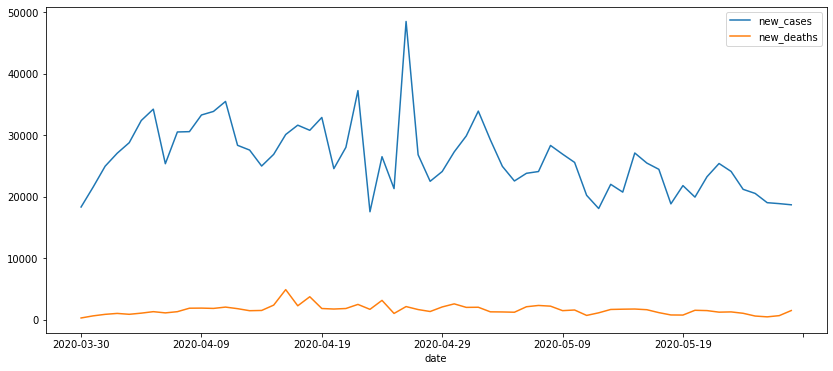

In [183]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-60:].plot.line(figsize=(14,6))

In [0]:
state = 'MN'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state]\
.rolling(window=7).mean()


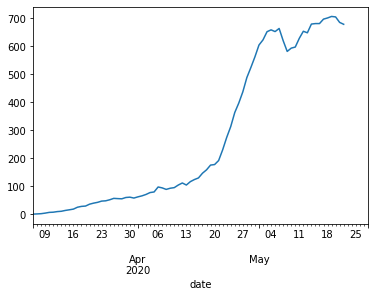

In [187]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [158]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

52634

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'][['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [160]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,286.0,895.0,71079.0,5183.0,76262.0
1,438.0,1516.0,63965.0,7529.0,71494.0
2,350.0,1766.0,-18947.0,7948.0,-10999.0
3,325.0,1130.0,51311.0,6465.0,57776.0
4,297.0,1139.0,76234.0,7598.0,83832.0
5,174.0,1026.0,77174.0,5350.0,82524.0
6,92.0,295.0,78760.0,4995.0,83755.0


# Socrata (San Francisco) Data

In [161]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [164]:
results_df.case_disposition.unique()

array(['Confirmed', 'Death'], dtype=object)

In [0]:
res = results_df.astype({'case_count':'int16'})

In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [167]:
dfresDead.groupby('date').sum().tail(5)

,case_count
date,
2020-05-08T00:00:00.000,1
2020-05-09T00:00:00.000,2
2020-05-12T00:00:00.000,1
2020-05-15T00:00:00.000,1
2020-05-17T00:00:00.000,1


In [168]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail()

,new_cases
date,
2020-05-22T00:00:00.000,22
2020-05-23T00:00:00.000,21
2020-05-24T00:00:00.000,14
2020-05-25T00:00:00.000,22
2020-05-26T00:00:00.000,13


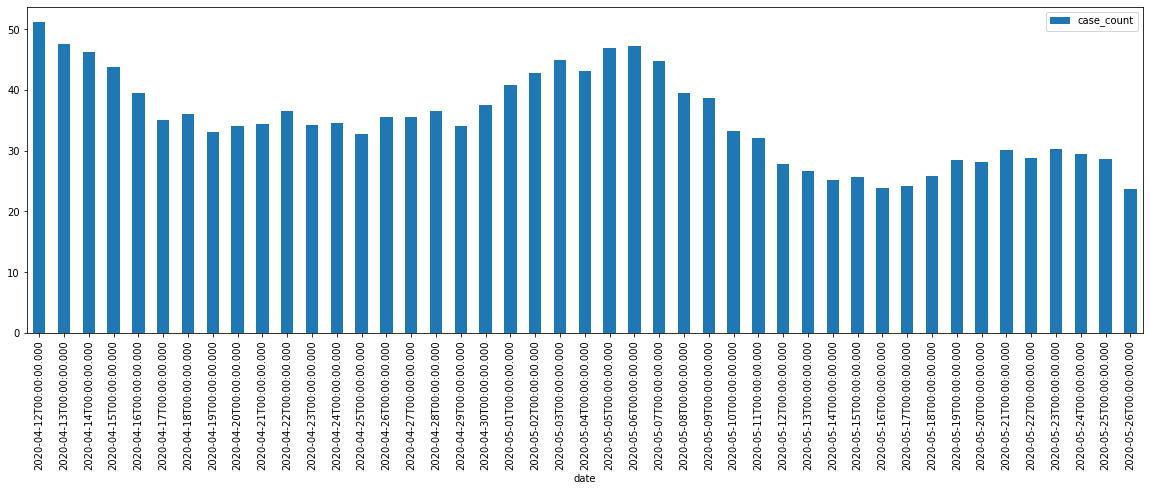

In [169]:
dfresConf.groupby('date').sum().rolling(window=7).mean()[-45:].plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [171]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-05-24,403,14.0,11307.0,51.0,255.0
2020-05-25,417,14.0,11587.0,51.0,262.0
2020-05-26,420,14.0,11796.0,52.0,269.0
2020-05-27,430,14.0,12064.0,52.0,274.0
2020-05-28,436,14.0,12428.0,52.0,289.0


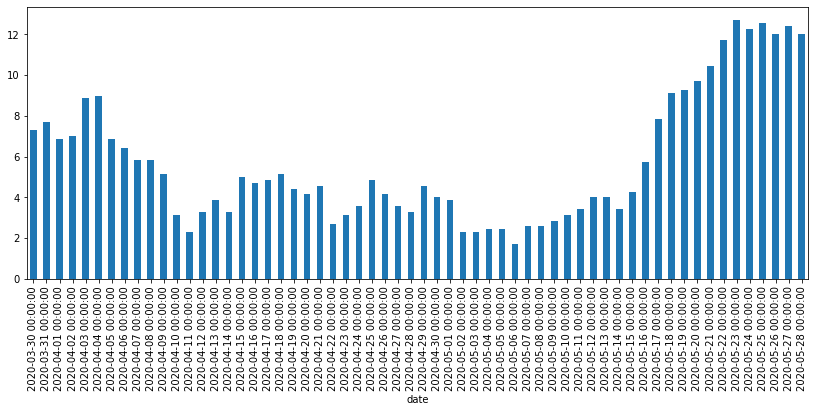

In [172]:
chart= df.positive.diff().rolling(window=7).mean()[-60:].plot.bar(figsize=(14,5))

In [173]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.17%
Marin Population Tested: 4.79%


In [174]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-05-24    12.285714
2020-05-25    12.571429
2020-05-26    12.000000
2020-05-27    12.428571
2020-05-28    12.000000
Name: positive, dtype: float64

In [175]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(28)[::-1].positive.diff()


date
2020-05-01       NaN
2020-05-02    1755.0
2020-05-03    1419.0
2020-05-04    1321.0
2020-05-05    1275.0
2020-05-06    2603.0
2020-05-07    1799.0
2020-05-08    1898.0
2020-05-09    2049.0
2020-05-10    2119.0
2020-05-11    1259.0
2020-05-12    1443.0
2020-05-13    1759.0
2020-05-14    2023.0
2020-05-15    1772.0
2020-05-16    1857.0
2020-05-17    2046.0
2020-05-18    1591.0
2020-05-19    1365.0
2020-05-20    2262.0
2020-05-21    2140.0
2020-05-22    2247.0
2020-05-23    2187.0
2020-05-24    2079.0
2020-05-25    1848.0
2020-05-26    2175.0
2020-05-27    2247.0
2020-05-28    2717.0
Name: positive, dtype: float64

In [176]:
dfCovidtracking[dfCovidtracking.state=='CA'][::-1].positive.diff().max()

2717.0